# Preparing basic tools

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

If the image is 8-bit unsigned, it is displayed as is.
<br>If the image is 16-bit unsigned or 32-bit integer, the pixels are divided by 256. That is, the value range [0,255*256] is mapped to [0,255].
<br>If the image is 32-bit floating-point, the pixel values are multiplied by 255. **That is, the value range [0,1] is mapped to [0,255].**

In [2]:
def read_image(path : str):
    image = cv.imread(path)
    image //= 255 # see above
    grey_img = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    return grey_img, np.shape(grey_img)

In [3]:
def identify_classes(X):
    return np.unique(X)

In [4]:
def display_image(title:str, image):
    cv.imshow(title, image)
    cv.waitKey()
    cv.destroyAllWindows()

In [82]:
def gauss_noise(X, m, n, cl1, cl2, m1, sig1, m2, sig2):
    gaussian_class_1 = np.random.normal(m1, sig1, (m,n))
    gaussian_class_1[X == cl2] = 0
    gaussian_class_2 = np.random.normal(m2, sig2, (m,n)) # will probably have to use np.where class == {1,2}
    gaussian_class_2[X == cl1] = 0
    noise = gaussian_class_1 + gaussian_class_2

    return noise

In [101]:
def error_rate(tolerance, A, B, m, n):
    return 1 - ((abs(A.clip(0,1) - B.clip(0,1)) <= tolerance).sum())/(m*n)

In [102]:
def evaluate_kmeans(k, A, B):
    shape = A.shape
    
    model = KMeans(n_clusters=k, random_state=0).fit(B.clip(0,1).reshape(-1,1))
    values = model.cluster_centers_
    labels = model.labels_
    img_seg = values[labels].reshape(shape)
    
    return img_seg, error_rate(0.1, img_seg, A, shape[0], shape[1])

# Puisqu'il s'agit de segmenter ... segmentons !

In [46]:
path = './images_BW/cible2.bmp'
image, shape = read_image(path)
cl1, cl2 = identify_classes(image)
print(f'classe 1 : {cl1}, classe 2 : {cl2}')

classe 1 : 0, classe 2 : 1


In [47]:
display_image('image', 255*image)

---

In [64]:
noisy = (image + gauss_noise(image, shape[0], shape[1],cl1, cl2, 0, 1, 0, 0)).clip(0,1)
noisy_1 = (noisy + gauss_noise(image, shape[0], shape[1],cl1, cl2, 0, 0, 0, 1)).clip(0,1)
noice = [noisy, noisy_1]
combine_noisy = np.concatenate(tuple(noice), axis=1)

display_image('Noisy, Noisy_1', combine_noisy)

In [66]:
img_seg, error = evaluate_kmeans(2, image, noisy_1)

In [67]:
error

0.52252197265625

In [68]:
display_image('Noisy image, KMeans, Image', np.concatenate((noisy_1, img_seg, image), axis=1))

---

In [1]:
from basictools import *
from scipy.stats import norm

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
def calc_prior(X, m, n, cl1, cl2):
    return ((X == cl1).sum()) / (m*n), ((X == cl2).sum()) / (m*n) # p(cl1), p(cl2) estimates

def calc_posterior_Gauss(Y, m, n, cl1, cl2, p1, p2, m1, sig1, m2, sig2):
    # posterior = p(X | Y) = p(Y|X)p(X) / sum(p(Y|X)p(X)) for each class X
    flat_Y = Y.reshape(-1,1)

    if (p1, p2, m1, sig1, m2, sig2) == (0, 0, 0, 0, 0, 0):
        post_cl1 = np.invert(flat_Y)
        post_cl2 = flat_Y
    else:
        norm_1 = norm(m1, sig1)
        norm_2 = norm(m2, sig2)
        
        f1 = p1*norm_1.pdf(flat_Y - cl1) # this way we call stats.norm only once
        f2 = p2*norm_2.pdf(flat_Y - cl2)
        
        post_cl1 = (f1 / (f1 + f2))
        post_cl2 = (f2 / (f1 + f2))
        
        # posterior = np.concatenate((post_cl1, post_cl2))
        # assert np.prod(posterior.shape) == m*n*2, 'posterior shape should be m*n*2'
    
    
    return post_cl1, post_cl2

def posterior_sampling(post_cl1, post_cl2, cl1, cl2, m, n): # tirage_apost
    sample = np.random.rand(m*n).reshape(-1,1) # m*n samples from uniform distribution over [0,1)
    
    condition1 = sample < post_cl1 # we draw cl1 with posterior probability of cl1 aka when our uniform sample(i) < post_cl1(i) and cl2 otherwise
    condition2 = sample < post_cl2
    X_est = (cl1 * condition1) + (cl2 * condition2)
    
    return X_est

def init_param(Y, cl1, cl2): # initialize an estimate of X from KMeans
    X_init, _ = evaluate_kmeans(2, Y, Y)
    X_init[X_init == np.unique(X_init)[0]] = cl1
    X_init[X_init == np.unique(X_init)[1]] = cl2
    
    return X_init

def est_empirical(X, Y, cl1, cl2): # Empirical estimates of parameters
    Y_flat = Y.reshape(-1,1)
    X_flat = X.reshape(-1,1)
    
    p1 = (X_flat == cl1).sum() / X_flat.shape[0] # frequency estimates
    p2 = (X_flat == cl2).sum() / X_flat.shape[0]
    m1 = (Y_flat[X_flat == cl1] - cl1).sum() / (X_flat == cl1).sum() # means over noise realizations
    m2 = (Y_flat[X_flat == cl2] - cl2).sum() / (X_flat == cl2).sum()
    sig1 = np.sqrt((((Y_flat[X_flat == cl1] - cl1) - m1)**2).sum() / (X_flat == cl1).sum()) # stds over noise realizations
    sig2 = np.sqrt((((Y_flat[X_flat == cl2] - cl2) - m2)**2).sum() / (X_flat == cl2).sum())
    
    return p1, p2, m1, sig1, m2, sig2

def calc_SEM(Y, m, n, cl1, cl2, p10, p20, m10, sig10, m20, sig20, nb_iter):
    # Y_flat = Y.reshape(-1,1)
    dic = {'p1':[p10], 'p2':[p20], 'm1':[m10], 'm2':[m20], 'sig1':[sig10], 'sig2':[sig20]}
    
    for _ in range(nb_iter):
        # Calculate posterior with current parameters
        post1, post2 = calc_posterior_Gauss(Y, m, n, cl1, cl2, p10, p20, m10, sig10, m20, sig20)
        
        # Sample X from posterior distribution
        X_est = posterior_sampling(post1, post2, cl1, cl2, m, n)
        
        # Empirically estimates of parameters from X_est
        p10, p20, m10, sig10, m20, sig20 = est_empirical(X_est, Y, cl1, cl2)
        
        # To plot convergence
        dic['p1'].append(p10)
        dic['p2'].append(p20)
        dic['m1'].append(m10)
        dic['m2'].append(m20)
        dic['sig1'].append(sig10)
        dic['sig2'].append(sig20)
    
    return p10, p20, m10, sig10, m20, sig20, dic

def calc_EM(Y, m, n, cl1, cl2, p10, p20, m10, sig10, m20, sig20, nb_iterEM):
    Y_flat = Y.reshape(-1,1)
    dic = {'p1':[p10], 'p2':[p20], 'm1':[m10], 'm2':[m20], 'sig1':[sig10], 'sig2':[sig20]}
    
    for _ in range(nb_iterEM):
        # Expectation
        post1, post2 = calc_posterior_Gauss(Y, m, n, cl1, cl2, p10, p20, m10, sig10, m20, sig20)
       
        # Maximization
        p10 = post1.sum()/len(post1)
        p20 = post2.sum()/len(post2)
        m10 = (Y_flat*post1).sum()/post1.sum()
        sig10 = np.sqrt(((((Y_flat - m10)**2) * post1).sum() / post1.sum()))
        m20 = ((Y_flat - cl2)*post2).sum()/post2.sum()
        sig20 = np.sqrt((((((Y_flat - cl2) - m20)**2) * post2).sum() / post2.sum()))
        
        # To plot convergence
        dic['p1'].append(p10)
        dic['p2'].append(p20)
        dic['m1'].append(m10)
        dic['m2'].append(m20)
        dic['sig1'].append(sig10)
        dic['sig2'].append(sig20)
    
    return p10, p20, m10, sig10, m20, sig20, dic

In [3]:
path = './images_BW/cible2.bmp'
X, shape = read_image(path)
display_image('X', X * 255) # displays X

cl1, cl2 = identify_classes(X) # identify image classes (two in our case)
print(f'Class 1 : {cl1} (black)\nClass 2 : {cl2} (white)') 

m, n = shape[0], shape[1] # X shape

p1, p2 = calc_prior(X, m, n, cl1, cl2) # priors of each class
print(f'\np(cl1) = p1 = {p1}\np(cl2) = p2 = {p2}')

m1, sig1, m2, sig2 = .2, .2, -.3, .2 # gaussian noise parameters    
Y = X + gauss_noise(X, m, n, cl1, cl2, m1, sig1, m2, sig2) # adding noise to image
display_image('Y', Y)

Class 1 : 0 (black)
Class 2 : 1 (white)

p(cl1) = p1 = 0.69488525390625
p(cl2) = p2 = 0.30511474609375


In [4]:

################################################################################################
# Hocus pocus, you lost your focus ! and forgot everything you knew about the above parameters #
################################################################################################

p1, p2, m1, m2, sig1, sig2 = 0, 0, 0, 0, 0, 0 # he 4gett ... but he also estimett !
p1, p2, m1, sig1, m2, sig2 = est_empirical(init_param(Y, cl1, cl2), Y, cl1, cl2) # empirically estimating a starting point for EM & SEM algorithms

In [5]:
p1, p2, m1, sig1, m2, sig2 # first estimates

(0.637115478515625,
 0.362884521484375,
 0.16247527618680982,
 0.16630425144289418,
 -0.3123948928799015,
 0.17891306044730698)

---

Let's manually test each step of SEM

Actual parameters : **m1, sig1, m2, sig2 = .2, .2, -.3, .2**
- Compute posterior
- Sample X_est from posterior
- Estimate parameters empirically

In [6]:
post1, post2 = calc_posterior_Gauss(Y, m, n, cl1, cl2, p1, p2, m1, sig1, m2, sig2)

In [7]:
display_image('post1 & post2', np.concatenate((post1.reshape(m,n), post2.reshape(m,n)), axis=1))

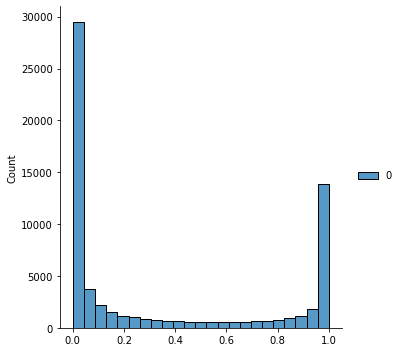

In [8]:
sns.displot(post2)

In [9]:
x_est = posterior_sampling(post1, post2, cl1, cl2, m, n)

In [10]:
display_image('x_est', x_est.reshape(m,n)*255)

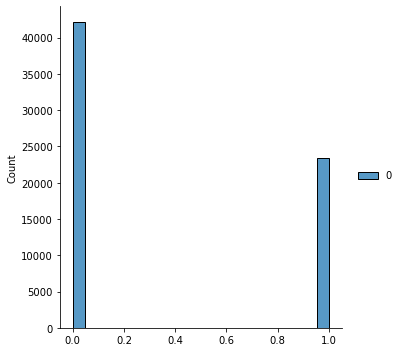

In [11]:
sns.displot(x_est)

In [12]:
(x_est == 0).sum()/len(x_est)

0.643798828125

In [13]:
(x_est == 1).sum()/len(x_est)

0.356201171875

In [14]:
p1, p2, m1, sig1, m2, sig2 = est_empirical(x_est, Y, cl1, cl2)
p1, p2, m1, sig1, m2, sig2

(0.643798828125,
 0.356201171875,
 0.17283875189555606,
 0.17894766258771708,
 -0.3212729301123655,
 0.19602889031532778)

One iteration yields :

(0.643798828125,
 0.356201171875,
 0.17283875189555606,
 0.17894766258771708,
 -0.3212729301123655,
 0.19602889031532778)

 VS 

 (0.637115478515625,
 0.362884521484375,
 0.16247527618680982,
 0.16630425144289418,
 -0.3123948928799015,
 0.17891306044730698)

 with real parameters p1, p2, m1, sig1, m2, sig2 = .69, .31, .2, .2, -.3, .2

 **This iteration is moving in the right direction**

In [15]:
post1, post2 = calc_posterior_Gauss(Y, m, n, cl1, cl2, p1, p2, m1, sig1, m2, sig2)
x_est = posterior_sampling(post1, post2, cl1, cl2, m, n)
p1, p2, m1, sig1, m2, sig2 = est_empirical(x_est, Y, cl1, cl2)

In [16]:
p1, p2, m1, sig1, m2, sig2

(0.647369384765625,
 0.352630615234375,
 0.17836935964956752,
 0.18528323070843816,
 -0.32630381276756,
 0.20458693822171517)

nope

In [17]:
post1, post2 = calc_posterior_Gauss(Y, m, n, cl1, cl2, p1, p2, m1, sig1, m2, sig2)
x_est = posterior_sampling(post1, post2, cl1, cl2, m, n)
p1, p2, m1, sig1, m2, sig2 = est_empirical(x_est, Y, cl1, cl2)
p1, p2, m1, sig1, m2, sig2

(0.65155029296875,
 0.34844970703125,
 0.18218372632646845,
 0.1885608117656777,
 -0.32749289607225274,
 0.20916062281838443)

In [18]:
post1, post2 = calc_posterior_Gauss(Y, m, n, cl1, cl2, p1, p2, m1, sig1, m2, sig2)
x_est = posterior_sampling(post1, post2, cl1, cl2, m, n)
p1, p2, m1, sig1, m2, sig2 = est_empirical(x_est, Y, cl1, cl2)
p1, p2, m1, sig1, m2, sig2

(0.652069091796875,
 0.347930908203125,
 0.18364297878681815,
 0.19043679575004122,
 -0.3294966106500152,
 0.2115261247937386)

In [19]:
post1, post2 = calc_posterior_Gauss(Y, m, n, cl1, cl2, p1, p2, m1, sig1, m2, sig2)
x_est = posterior_sampling(post1, post2, cl1, cl2, m, n)
p1, p2, m1, sig1, m2, sig2 = est_empirical(x_est, Y, cl1, cl2)
p1, p2, m1, sig1, m2, sig2

(0.6525115966796875,
 0.3474884033203125,
 0.1847023272799449,
 0.1918461024304348,
 -0.3308658622947369,
 0.21301070737505384)

---

EM
p1: 0.709243694146873, p2 : 0.290756305853127, m1 : 0.20622373215082804, sig1 : 0.2026409429877486, m2 : -0.28884128107182494, sig2 : 0.19706673863521684


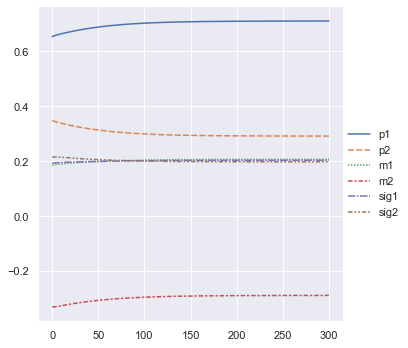

In [20]:

p1_em, p2_em, m1_em, sig1_em, m2_em, sig2_em, dic_em = calc_EM(Y, m, n, cl1, cl2, p1, p2, m1, sig1, m2, sig2, 300) # EM algorithm estimates

print(f'EM\np1: {p1_em}, p2 : {p2_em}, m1 : {m1_em}, sig1 : {sig1_em}, m2 : {m2_em}, sig2 : {sig2_em}')

df_em = pd.DataFrame.from_dict(dic_em)

sns.set()
sns.relplot(data=df_em, kind='line') # Plotting evolution of parameters over EM iterations
plt.show()

# si le bruit 0, 0, .6, .6 ça converge vers un minimum local        

In [23]:
p1_sem, p2_sem, m1_sem, sig1_sem, m2_sem, sig2_sem, dic_sem = calc_SEM(Y, m, n, cl1, cl2, p1, p2, m1, sig1, m2, sig2, 100)
print(f'SEM\np1: {p1_sem}, p2 : {p2_sem}, m1 : {m1_sem}, sig1 : {sig1_sem}, m2 : {m2_sem}, sig2 : {sig2_sem}')

SEM
p1: 0.710906982421875, p2 : 0.289093017578125, m1 : 0.20661051331503547, sig1 : 0.20270672184628788, m2 : -0.2868872836436853, sig2 : 0.19556672697276453


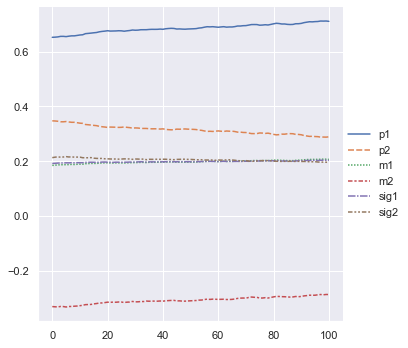

In [24]:
df_sem = pd.DataFrame.from_dict(dic_sem)
sns.relplot(data=df_sem, kind='line') # Plotting evolution of parameters over SEM iterations